In [3]:
from google.colab import files
import io

print("Upload calories.csv:")
uploaded = files.upload()

Upload calories.csv:


Saving archive (2).zip to archive (2).zip


In [4]:
!unzip 'archive (2).zip' -q
print("Unzipped! Now calories.csv is ready.")

Archive:  archive (2).zip
caution: filename not matched:  -q
Unzipped! Now calories.csv is ready.


In [6]:
import zipfile
import os
print("Current files in directory:")
os.system('ls -la')
zip_path = 'archive (2).zip'
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(" Unzipped successfully! Extracted files:")
    os.system('ls -la *.csv')
else:
    print(" ZIP file not found. Re-upload it.")

Current files in directory:
 Unzipped successfully! Extracted files:


Dataset shape: (15000, 9)

First 5 rows:
    User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  \
0  14733363    male   68   190.0    94.0      29.0       105.0       40.8   
1  14861698  female   20   166.0    60.0      14.0        94.0       40.3   
2  11179863    male   69   179.0    79.0       5.0        88.0       38.7   
3  16180408  female   34   179.0    71.0      13.0       100.0       40.5   
4  17771927  female   27   154.0    58.0      10.0        81.0       39.8   

   Calories  
0     231.0  
1      66.0  
2      26.0  
3      71.0  
4      35.0  

Missing values: 0

Descriptive statistics:
            User_ID           Age        Height        Weight      Duration  \
count  1.500000e+04  15000.000000  15000.000000  15000.000000  15000.000000   
mean   1.497736e+07     42.789800    174.465133     74.966867     15.530600   
std    2.872851e+06     16.980264     14.258114     15.035657      8.319203   
min    1.000116e+07     20.000000    123.000000     

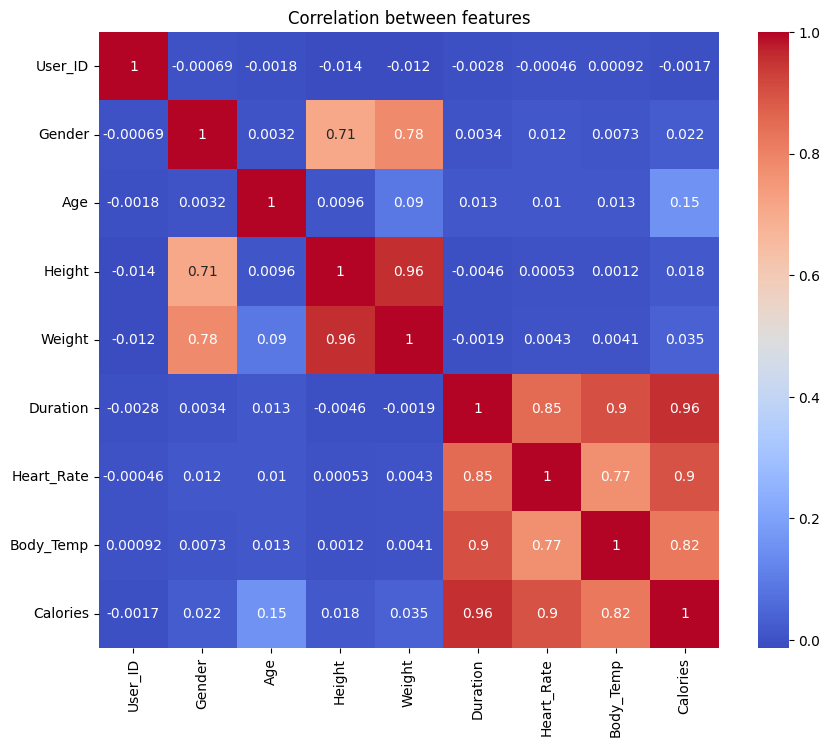

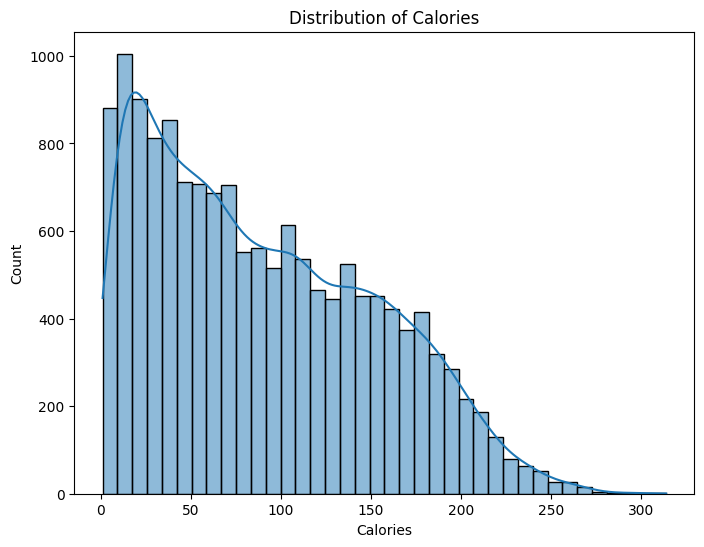

Rows after outlier removal: 14996

Data after scaling (sample):
        Age    Height    Weight  Duration  Heart_Rate  Body_Temp
0  1.485531  1.089932  1.266326  1.619826    0.991050   0.994314
1 -1.342063 -0.593475 -0.995254 -0.183615   -0.157861   0.352622
2  1.544439  0.318370  0.268570 -1.265680   -0.784539  -1.700791
3 -0.517348  0.318370 -0.263567 -0.303845    0.468818   0.609299
4 -0.929705 -1.435178 -1.128288 -0.664533   -1.515665  -0.289069


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load the data from unzipped CSV
df = pd.read_csv('calories.csv')

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values:", df.isnull().sum().sum())

# Descriptive statistics
print("\nDescriptive statistics:")
print(df.describe())

# Encode Gender FIRST (before correlation)
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
print("\nGender encoding: 0=male, 1=female")
print(df['Gender'].value_counts())

# Now Correlation heatmap (after encoding)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between features')
plt.show()

# Plot distribution of Calories
plt.figure(figsize=(8, 6))
sns.histplot(df['Calories'], kde=True)
plt.title('Distribution of Calories')
plt.show()

# Drop User_ID
df.drop('User_ID', axis=1, inplace=True)

# Remove outliers in Calories using IQR
Q1 = df['Calories'].quantile(0.25)
Q3 = df['Calories'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Calories'] >= Q1 - 1.5*IQR) & (df['Calories'] <= Q3 + 1.5*IQR)]
print("Rows after outlier removal:", len(df))

# Scale numerical features
features_to_scale = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
print("\nData after scaling (sample):")
print(df[features_to_scale].head())

Model summary:
                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 5.143e+04
Date:                Tue, 16 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:54:45   Log-Likelihood:                -45999.
No. Observations:               11996   AIC:                         9.201e+04
Df Residuals:                   11988   BIC:                         9.207e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         90.0289      0.198    4

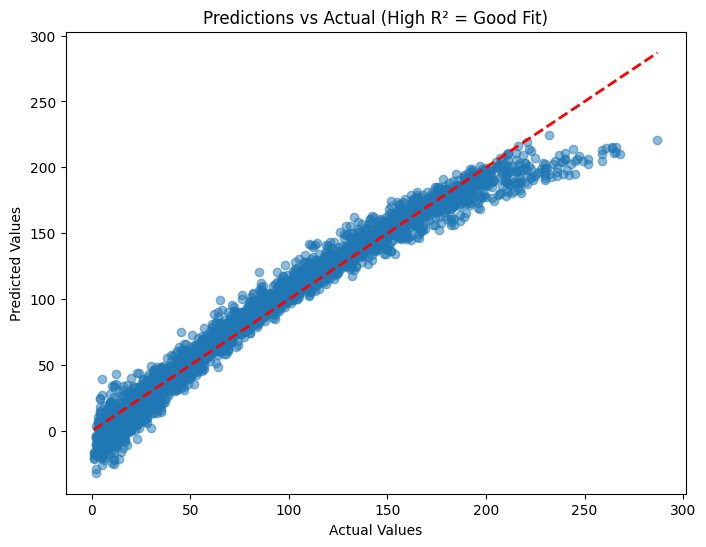

In [9]:
import statsmodels.api as sm

# Prepare features and target
X = df.drop('Calories', axis=1)
y = df['Calories']
X = sm.add_constant(X)  # Add intercept

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = sm.OLS(y_train, X_train).fit()

print("Model summary:")
print(model.summary())

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMSE: {mse:.2f}")
print(f"R²: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual (High R² = Good Fit)')
plt.show()

In [10]:
# New data point (assumptions: male=0, Body_Temp=38.0)
new_data = pd.DataFrame({
    'const': [1],
    'Gender': [0],  # 0=male (change to 1 for female)
    'Age': [25],
    'Height': [175],
    'Weight': [70],
    'Duration': [60],
    'Heart_Rate': [130],
    'Body_Temp': [38.0]
})

# Scale new data
new_data[features_to_scale] = scaler.transform(new_data[features_to_scale])

# Predict
prediction = model.predict(new_data)[0]
print(f"Predicted calories burned for Brisk Walking: {prediction:.2f} calories")

Predicted calories burned for Brisk Walking: 477.46 calories
